In [11]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import LogNorm

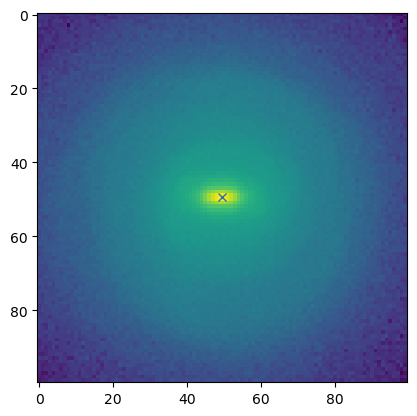

In [37]:
# read the file
fileName = 'subhalo184932_snap99.fits'
# fileName = 'test.fits'
hdul = fits.open(fileName)
pic = hdul[0].data
pic = np.rot90(pic)  # spin
# headers = hdul[0].header
# print(headers['HALFRAD']) #  pixel？
plt.imshow(pic,norm = LogNorm())
# center
plt.plot((pic.shape[0]-1)/2,(pic.shape[1]-1)/2,'x')

傅立叶方法：
Athanassoula E., Misiriotis A., 2002, MNRAS, 330, 35
1. 分割为等间距的圆环
2. 按角度取样(能否自适应取样，内区角度间隔取较大值？)
3. fft（/N）
4. A2：实部

单位：面密度  
注意取等  
等效于一个坐标转换，但这时采用光线追踪的思路不行

In [38]:
# # “光线追踪”思路

# # setup
# rmax = 50
# dr = 1
# rs = np.arange(0,rmax,dr)
# nannuli = len(rs)

# ntheta = 128
# thetas = np.linspace(0,2*np.pi,ntheta+1)[:-1]
# dtheta = thetas[1]-thetas[0]

# # ------------

# center = [(pic.shape[0]-1)/2,(pic.shape[1]-1)/2]

# polar = []
# temp=[]
# # go through every interval
# for ri in range(nannuli):
#     for thetai in range(ntheta):
#         xi = ri*np.cos(thetai)+center[0]
#         yi = ri*np.sin(thetai)+center[1]
#         xifloor = int(np.floor(xi)); xiceil = int(np.ceil(xi)); yifloor = int(np.floor(yi)); yiceil = int(np.ceil(yi))
#         datai = (xiceil-xi)*(yiceil-yi)*pic[xifloor,yifloor] + (xi-xifloor)*(yiceil-yi)*pic[xiceil,yifloor] + \
#                 (xiceil-xi)*(yi-yifloor)*pic[xifloor,yiceil] + (xi-xifloor)*(yi-yifloor)*pic[xiceil,yiceil]
#         polar.append(datai)
#         temp.append([np.round(xi),np.round(yi)])
# polar = np.array(polar)
# polar.resize((nannuli,ntheta))
# plt.imshow(polar,norm = LogNorm())
        

In [39]:
# # 不行的原因
# plt.imshow(pic,norm = LogNorm())
# # center
# # plt.plot((pic.shape[0]-1)/2,(pic.shape[1]-1)/2,'x')
# temp = np.array(temp)
# plt.plot(temp[:,0],temp[:,1],'.')

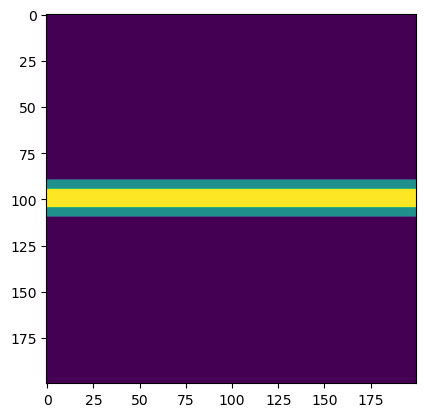

In [46]:
# # test picture
# pic = np.ones((200,200))
# pic[90:110,:]+=1
# # pic[50:,40:60]+=1
# pic[95:105,:]+=1
# # pic[50:,45:55]+=1
# plt.imshow(pic)

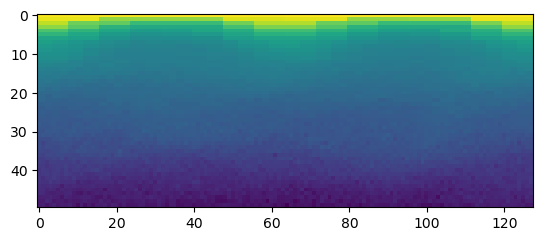

In [41]:
# setup
rmax = 50
dr = 1  # dr >= 1
rs = np.arange(0,rmax,dr)
nannuli = len(rs)

ntheta_index = 7
ntheta = 2**ntheta_index
dtheta = 2*np.pi/ntheta

r_theta = np.zeros((nannuli,ntheta))
count = np.zeros((nannuli,ntheta))

adaptive_flag = 1

# ------------

center = [(pic.shape[0]-1)/2,(pic.shape[1]-1)/2]

def radius(x,y,center):
    r = np.sqrt((x-center[0])**2+(y-center[1])**2)
    return r
def theta(x,y,center):
    t = np.arctan2((x-center[0]),(y-center[1]))+np.pi
    return t


# go through the picture
for xi in range(pic.shape[0]):
    for yi in range(pic.shape[1]):
        if radius(xi,yi,center) < rmax:
            rn = int(np.floor(radius(xi,yi,center)/dr))
            thetan = int(np.floor(theta(xi,yi,center)/dtheta))
            r_theta[rn,thetan] += pic[xi,yi]
            count[rn,thetan] += 1

if adaptive_flag:
# adaptive dtheta
    index = ntheta_index
    while np.all(count) == False and index >= 0:
        max_0 = np.max(np.arange(nannuli)[~np.all(count,axis=1)])+1 # max r that has a count 0
        r_theta[0:max_0,:] = 0
        count[0:max_0,:] = 0
        index -= 1
        ntheta_adaptive = 2**index
        dtheta_adaptive = 2*np.pi/ntheta_adaptive
        rate = 2**(ntheta_index-index)
        # print(ntheta_adaptive,max_0)
        for xi in range(pic.shape[0]):
            for yi in range(pic.shape[1]):
                if radius(xi,yi,center) < max_0*dr: 
                    rn = int(np.floor(radius(xi,yi,center)/dr))
                    thetan_adaptive = int(np.floor(theta(xi,yi,center)/dtheta_adaptive))
                    r_theta[rn,thetan_adaptive*rate:(thetan_adaptive+1)*rate] += pic[xi,yi]
                    count[rn,thetan_adaptive*rate:(thetan_adaptive+1)*rate] += 1
        # move to the left
        # r_theta[0:max_0,:] = np.roll(r_theta[0:max_0,:],-int(rate/2),axis=1)
        # count[0:max_0,:] = np.roll(count[0:max_0,:],-int(rate/2),axis=1)
        # don't need to move

count[np.where(count==0)] = np.inf
pic_polar = r_theta/count
pic_polar = pic_polar/ntheta
# pic_polar = pic_polar/3*np.size(pic_polar)**2/np.size(pic)*dr  # a coefficient which i haven't finish
pic_polar = pic_polar/np.max(pic_polar)
plt.imshow(pic_polar,norm=LogNorm())
# plt.colorbar()

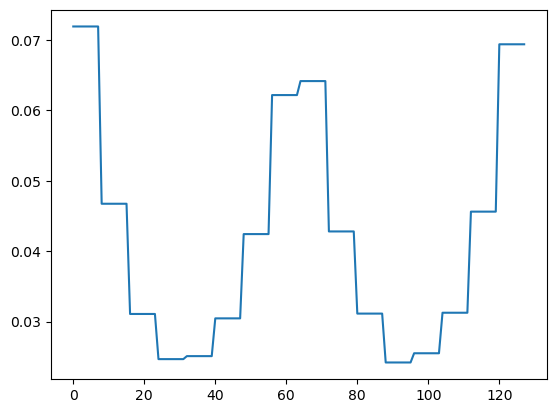

In [42]:
plt.plot(pic_polar[5,:])

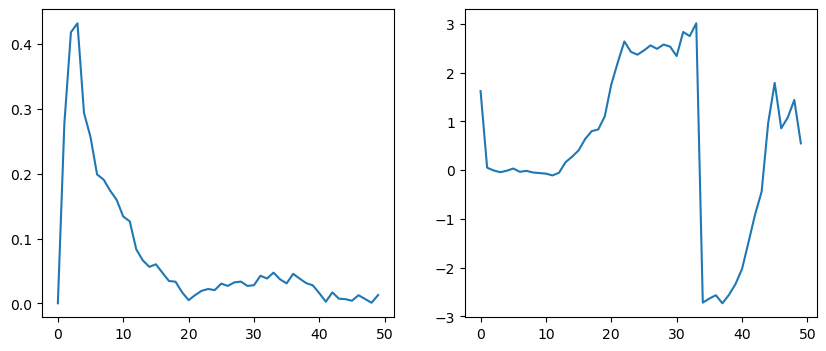

In [43]:
plt.figure(figsize=(10,4))
a2=[]
angle=[]
for ri in pic_polar:
    fft_r = np.fft.fft(ri)
    a0i = np.abs(np.real(fft_r[0]))
    a2i = np.abs(np.real(fft_r[2]))
    anglei = np.angle(fft_r[2])
    a2.append(a2i/a0i)
    angle.append(anglei)
a2 = np.array(a2)
angle = np.array(angle)
plt.subplot(121)
plt.plot(a2)
plt.subplot(122)
plt.plot(angle)